<a href="https://colab.research.google.com/github/jnels13/Screening-Childrens-Writing-Level-With-NLP/blob/main/Predicting_Children's_Writing_by_Grade_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Children's Grade-Group Writing Level**

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

import string
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Markdown, display

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 50)
import six
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import gensim

import pickle
import warnings
warnings.filterwarnings("ignore")

rand_state = 99

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joenelson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: No module named 'wordcloud'

### Import Dataset

In [ ]:
local_or_not = str(input("""Running on 'colab' or 'local'?"""))

In [ ]:
# Run this cell to load the corpus
if local_or_not == 'colab':
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0] 
    print("Confirmed that",file_name,"was uploaded.")

Saving Combined.csv to Combined (6).csv
Confirmed that Combined.csv was uploaded.


In [ ]:
if local_or_not == 'colab':
    data = pd.read_csv(io.BytesIO(uploaded[file_name]),
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
    print("Loading remote dataset")
elif local_or_not == 'local':
    data = pd.read_csv("Data/Combined.csv",
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
    print("Loaded local dataset")
else:
    print('You need to re-start the previous cells')

## __Categorize Text Samples and Labels__

In [ ]:
#Number of Texts
len(data.Grade)

289

In [ ]:
#Review counts per grade level
#Some texts were attributed to multiple grade levels, and thus were only assigned the lowest grade
#(The most obvious example of this is for high school, where most texts were assigned to grade 9)

data.Grade.value_counts().sort_index()

0     18
1     30
2     37
3     34
4     36
5     18
6     47
7      8
8      8
9     44
10     2
11     4
12     3
Name: Grade, dtype: int64

In [ ]:
#Categorize text samples into broader grade-groups due to limited corpus size

data.loc[(data['Grade'] >= 0) & (data['Grade'] <= 2), 'Category'] = '0-2'
data.loc[(data['Grade'] >= 3) & (data['Grade'] <= 4), 'Category'] = '3-4'
data.loc[(data['Grade'] >= 5) & (data['Grade'] <= 8), 'Category'] = '5-8'
data.loc[(data['Grade'] >= 9) & (data['Grade'] <= 12), 'Category'] = '9-12'

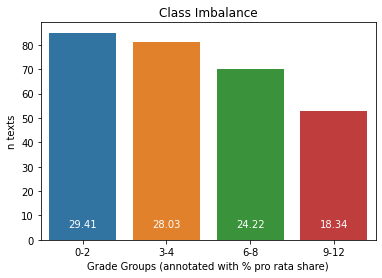

In [ ]:
#Visualize potential class imbalance
imbalance=data.Category.value_counts()
sns.barplot([0,1,2,3], imbalance)
plt.xticks([0,1,2,3],['0-2', '3-4', '6-8', '9-12'])
plt.xlabel('Grade Groups (annotated with % pro rata share)')
plt.ylabel('n texts')
plt.title('Class Imbalance')
tot=len(data.Category)
for i in range(4):
    plt.annotate(round(imbalance[i]/tot*(100),2),xy=(i-.17,5), color='white')
plt.show()

In [ ]:
data = data.drop(['Grade'], axis=1)

## Data Exploration & Preprocessing

In [ ]:
data.Text.head()

0    How Much I Know About Space I had just gone to...
1    My Favorite Pet My cat is fluffy. His name is ...
2    Sweet Spring Spring is sweet because we can go...
3    A Happy Day One day baby Josh came home. He wa...
4    My Trip to Mexico One time I went to Mexico. I...
Name: Text, dtype: object

In [ ]:
def apostrophes(data):
    """ 
    Remove all forms of apostrophes.
    """
    data2=data.replace('\'','')
    data3=data2.replace('``','')
    data4=data3.replace('’','')
    return(data4)

In [ ]:
def stopped_ (data):
    """
    Removes stopwords and punctuation from a given text.
    Also changes input to lower case.
    ** ALSO has words added to stopwords_list that frequently appear across all texts, 
    ** to try and make the texts more distinguishable.
    """
    stopwords_list = stopwords.words('english') #removing stopwords
    stopwords_list += list(string.punctuation)  #removing punctuation
    stopwords_list += ['like', 'one', 'day', 'get', 'mom', 'said',
                       'time', 'would', 'people', 'go', 'way'] 
                       # ********************************************************************************
                       # Words that appeared in 3 or 4 of the groups' top 10 word lists (on 6 iterations)
                       # They were derived from the word frequency charts, below
                       # ********************************************************************************
    data1 = [w.lower() for w in data]
    data2 = [w for w in data1 if w not in set(stopwords_list)]  # remove stopwords
    return(data2)

In [ ]:
def tokenize_ (text):
    return word_tokenize(text)

In [ ]:
def lemma_(data):
    """
    Applies the WordNetLemmatizer to the data 
    """
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(w) for w in data]     
    return(data)

In [ ]:
def lower(data):
    data2 = [w.lower() for w in data]
    return data2

In [ ]:
data['Text_BERT'] = data.Text.apply(tokenize_).apply(lower)

In [ ]:
data['Text_tokenized'] = data.Text.apply(tokenize_)

In [ ]:
data['Text_lemmatized'] = data.Text_tokenized.apply(stopped_)

In [ ]:
data.Text_lemmatized = data.Text_lemmatized.apply(lemma_)

In [ ]:
data.head()

In [ ]:
data['Text_tokenized'] = data['Text'].apply(apostrophes).apply(tokenize_)

In [ ]:
data['Text_lemmatized'] = data.Text_tokenized.apply(stopped_).apply(lemma_)

In [ ]:
data.head(10)

,Text,Category,Text_tokenized,Text_lemmatized
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien..."
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor..."
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, boat, riding, b..."
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, baby, josh, came, home, yellow, blanke..."
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, went, mexico, blast, met, went,..."
5,Happy Easter Once there was a hen. The hen was...,0-2,"[Happy, Easter, Once, there, was, a, hen, ., T...","[happy, easter, hen, hen, lonely, laid, egg, o..."
6,"Leaf Person One morning, I turned into a leaf ...",0-2,"[Leaf, Person, One, morning, ,, I, turned, int...","[leaf, person, morning, turned, leaf, person, ..."
7,Parrots Parrots are colorful. They have differ...,0-2,"[Parrots, Parrots, are, colorful, ., They, hav...","[parrot, parrot, colorful, different, color, b..."
8,"If I Were President If I were president, Id be...",0-2,"[If, I, Were, President, If, I, were, presiden...","[president, president, id, responsible, id, lo..."
9,My Dad I was at the hospital when my dad was d...,0-2,"[My, Dad, I, was, at, the, hospital, when, my,...","[dad, hospital, dad, dying, sister, lighting, ..."


The new column "Text_lemmatized" contains the lemmatized, tokenized texts with stop-words removed. 

### **Visualization of Corpus**

In [ ]:
#Review dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             289 non-null    object
 1   Category         289 non-null    object
 2   Text_tokenized   289 non-null    object
 3   Text_lemmatized  289 non-null    object
dtypes: object(4)
memory usage: 9.2+ KB


In [ ]:
# Create a column containing the number of words per each original text 
data['num_words'] = data['Text'].str.len()  

In [ ]:
# Create a column containing average word length for each original text 
temp_token_list = list(data['Text_tokenized'])
new_token_list = []
for item in temp_token_list:
    new_token_list.append(np.average([len(w) for w in item]))
data['avg_orig_word_len'] = new_token_list

In [ ]:
# Create a column containing average word length for each lemmatized text 
temp_lemma_list = list(data['Text_lemmatized'])
new_lemma_list = []
for item in temp_lemma_list:
    new_lemma_list.append(np.average([len(w) for w in item]))
data['avg_lem_word_len'] = new_lemma_list

In [ ]:
# Review new columns
data.head(5)

,Text,Category,Text_tokenized,Text_lemmatized,num_words,avg_orig_word_len,avg_lem_word_len
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien...",364,3.675000,5.184211
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor...",209,3.037037,4.631579
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, boat, riding, b...",255,3.383333,4.857143
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, baby, josh, came, home, yellow, blanke...",130,3.121212,4.769231
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, went, mexico, blast, met, went,...",242,3.131148,5.217391


In [ ]:
#Review descriptive statistics about the corpus before and after preprocessing
print(data.groupby('Category').describe().reset_index().sort_values('Category', ascending=True))

  Category num_words                            \
               count         mean          std   
0      0-2      85.0   406.200000   278.109982   
1      3-4      70.0  1131.971429   570.230997   
2      5-8      81.0  2784.740741  1618.645821   
3     9-12      53.0  4328.584906  2452.785265   

                                             \
     min      25%     50%      75%      max   
0   25.0   187.00   364.0   600.00   1609.0   
1  115.0   726.75  1210.0  1520.75   2725.0   
2  456.0  1852.00  2425.0  3388.00   9682.0   
3  144.0  2788.00  3568.0  5571.00  11311.0   

  avg_orig_word_len                      \
              count      mean       std   
0              85.0  3.544055  0.376101   
1              70.0  3.632297  0.288336   
2              81.0  3.875996  0.322997   
3              53.0  3.966335  0.367336   

                                           \
        min       25%       50%       75%   
0  2.857143  3.275229  3.529915  3.782609   
1  2.916667  3.461047 

When looking at the number of words per text, they follow a relatively predictable pattern, with the min/max, mean, and standard deviation increasing rather significantly with grade-group.  The average length of words (original and pre-processed) per grade-group level does not appear to correlate nearly as much, though; average word lengths are much closer and do trend up with grade-group, but are within 1-2 standard deviations of their neighbors. The visualizations below highlight these differences:

In [ ]:
# Gather most common words across the grade-groups

concat_0_2 = []
concat_3_4 = []
concat_5_8 = []
concat_9_12 = []

for i in range(len(data)):
    if data.Category[i] == '0-2':
      concat_0_2 += data.Text_lemmatized[i]
    elif data.Category[i] == '3-4':
      concat_3_4 += data.Text_lemmatized[i]
    elif data.Category[i] == '5-8':
      concat_5_8 += data.Text_lemmatized[i]
    elif data.Category[i] == '9-12':
      concat_9_12 += data.Text_lemmatized[i]

In [ ]:
group_0_2_freqdist = FreqDist(concat_0_2)
group_3_4_freqdist = FreqDist(concat_3_4)
group_5_8_freqdist = FreqDist(concat_5_8)
group_9_12_freqdist = FreqDist(concat_9_12)

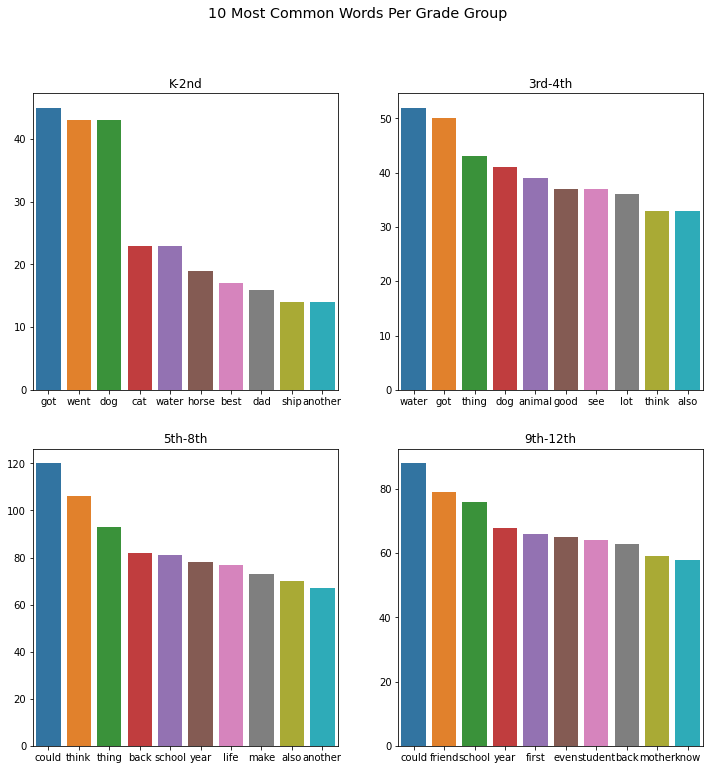

In [ ]:
#Visualize Frequency Distribution of 10 most common
n=10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
sns.barplot([x[0] for x in group_0_2_freqdist.most_common(n)], [x[1] for x in group_0_2_freqdist.most_common(n)], ax=ax1)
sns.barplot([x[0] for x in group_3_4_freqdist.most_common(n)], [x[1] for x in group_3_4_freqdist.most_common(n)], ax=ax2)
sns.barplot([x[0] for x in group_5_8_freqdist.most_common(n)], [x[1] for x in group_5_8_freqdist.most_common(n)], ax=ax3)
sns.barplot([x[0] for x in group_9_12_freqdist.most_common(n)],[x[1] for x in group_9_12_freqdist.most_common(n)],ax=ax4)
#Subplot titles
ax1.title.set_text('K-2nd')
ax2.title.set_text('3rd-4th')
ax3.title.set_text('5th-8th')
ax4.title.set_text('9th-12th')

# ax1.set_xlabel('Preprocessed Texts', size='large')

fig.suptitle('10 Most Common Words Per Grade Group', size='x-large')
plt.show()

The foregoing visualization was used to remove additional words that were common in at least 3 of the 4 grade-groups, essentially treating them as additional stopwords in the "stopped" function, above. This process was done iteratively, until the were words only common to 2 of the 4 groups. Accordingly, this visualization has had these additional stopwords removed.  <br><br>These words include: like, one, day, get, mom, said, time, would, people, go, + way. <br><br>



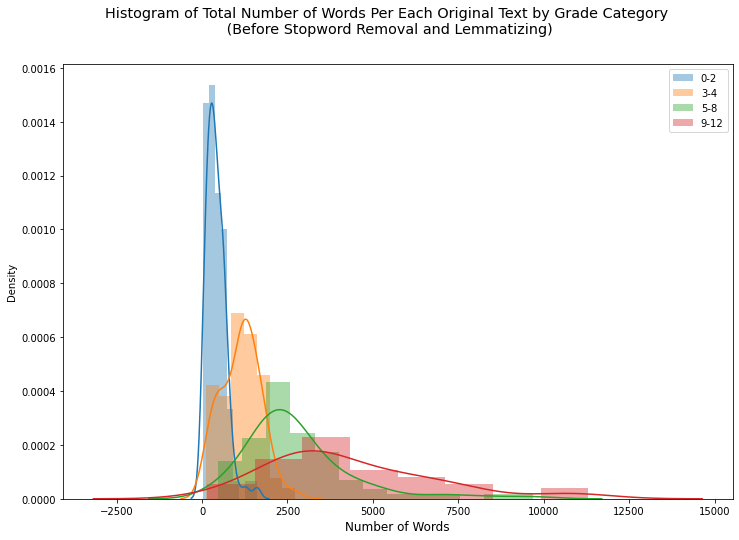

In [ ]:
#Distribution of Number of Words per Text
plt.figure(figsize=(12,8))
for name, group in data.groupby('Category'):
    sns.distplot(group['num_words'], label=name)
plt.legend()
plt.xlabel('Number of Words', size='large')
plt.suptitle('Histogram of Total Number of Words Per Each Original Text by Grade Category\n (Before Stopword Removal and Lemmatizing)', size='x-large')
plt.show()

The text lengths for K-2 grade are much shorter than the higher grades. Lengths of middle and high school texts are much more comparable.  This may be helpful to classify the texts, in addition to the NLP classifiers. <br><br><br> 

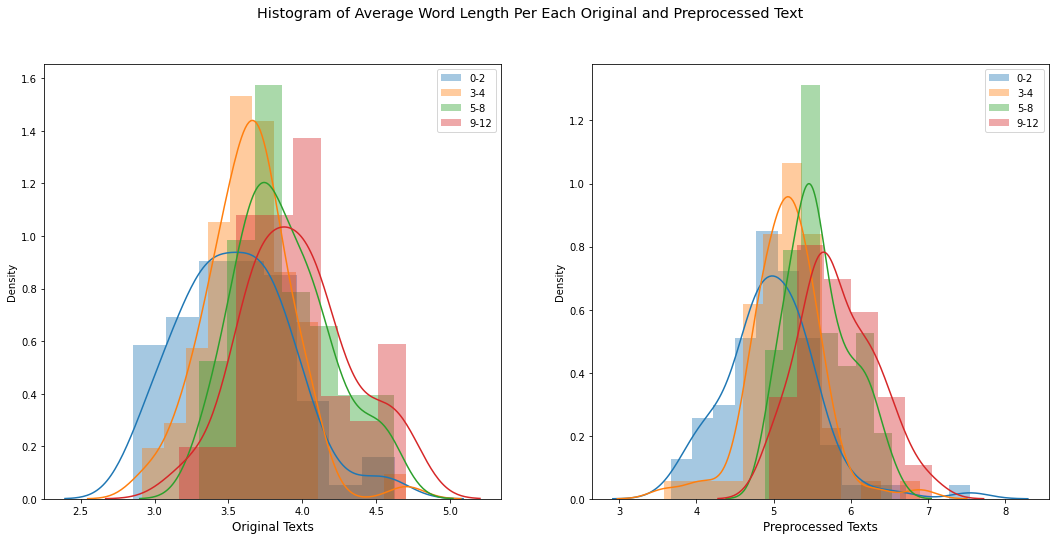

In [ ]:
#Visualize distribution of word lengths between original and preprocessed texts


fig, ax = plt.subplots(1,2, figsize=(18, 8))
ax0 = ax[0]
ax1 = ax[1]
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_orig_word_len'], label=name, ax=ax0)
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_lem_word_len'], label=name, ax=ax1)
ax0.set_xlabel('Original Texts', size='large')
ax0.legend()
ax1.set_xlabel('Preprocessed Texts', size='large')
ax1.legend()
fig.suptitle('Histogram of Average Word Length Per Each Original and Preprocessed Text', size='x-large')
plt.show()

    

Overall, there is a LOT of overlap in the distributions between all of the grade-groups, with the most striking being between the upper two.  The distributions of word lengths are much higher in the stopped/lemmatized group (peaking between 5 for stopped/lemmatized texts, compared to about 3.75 for the original texts.  The distributions of the original texts are also much closer together, likely due to the inclusion of the stop words. 

## Visualize the Text Itself: Wordclouds by Grade-Group

In [ ]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
def printmd(string):
    display(Markdown(string))

# Generate word cloud
def make_wordcloud(category_):
  wordcloud = WordCloud(width = 800, height = 600, 
                        random_state=rand_state, 
                        background_color='white', 
                        colormap='Dark2', 
                        collocations=False, 
                        stopwords = STOPWORDS).generate(' '.join(data['Text'].loc[data['Category']== category_]))
  # plot_cloud(wordcloud)
  # plt.title(category_)
  plt.figure( figsize=(8,6), facecolor='w')
  plt.imshow(wordcloud)
  plt.axis("off")
  x = '## **Grade-Group ' + category_ + '**'
  printmd(x)
  plt.tight_layout(pad=0)
  plt.show()

## **Grade-Group 0-2**

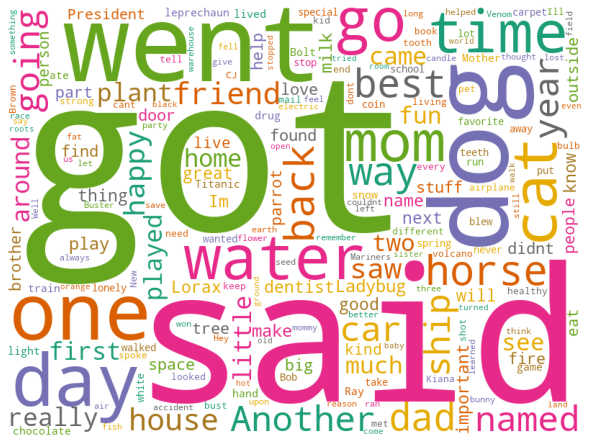

## **Grade-Group 3-4**

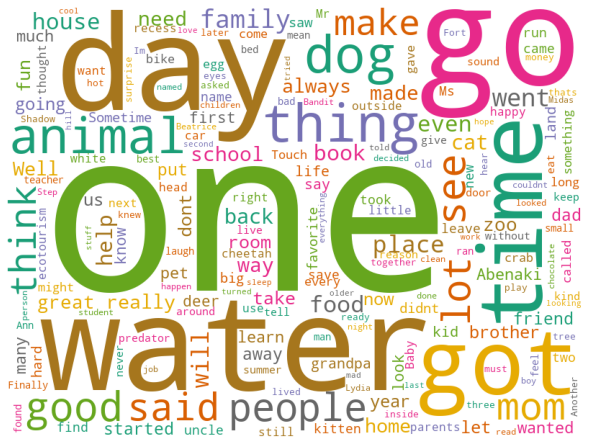

## **Grade-Group 5-8**

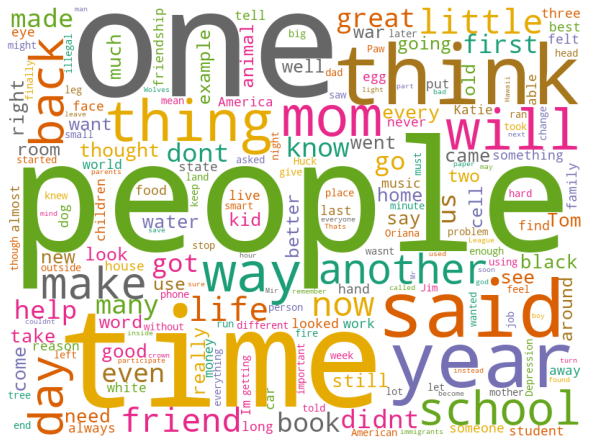

## **Grade-Group 9-12**

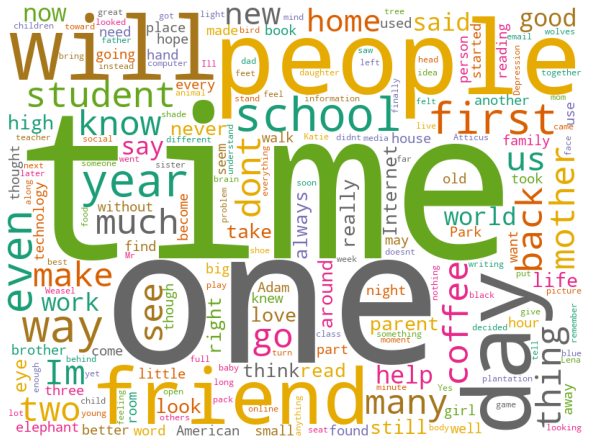

(None, None)

In [ ]:
make_wordcloud('0-2'), make_wordcloud('3-4')
make_wordcloud('5-8'), make_wordcloud('9-12')


Dogs and cats are important in younger grade levels, but drop off as age increases. "Mom" is always prominent, but becomes "mother" in high school (and "coffee" appears). "People" grows in frequency in middle and high school. "Time" appears to grow in frequency as grade levels increase.  

# **Weight and Vectorize the Texts**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Text_lemmatized'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [ ]:
# Y labels to use with all models
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

pickle_out = open("Encoder.pkl", "wb") 
pickle.dump(Encoder, pickle_out) 
pickle_out.close()

### **TF-IDF Weighting**

In [ ]:
lemmas = data['Text_lemmatized'].apply(lambda x: ' '.join(x))
lemma_Train_X = X_train.apply(lambda x: ' '.join(x))
lemma_Test_X  = X_test.apply(lambda x: ' '.join(x))

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(lemmas)

# Pickle Tfidf_vect 
pickle_out = open("Tfidf_vect.pkl", "wb") 
pickle.dump(Tfidf_vect, pickle_out) 
pickle_out.close()

# Get feature names to plot feature importances later
tfidf_names = Tfidf_vect.get_feature_names()
# Set coefs variables as globel
coefs_rf, coefs_svm, coefs_xgb = 0,0,0

X_train_tfidf = Tfidf_vect.transform(lemma_Train_X)
X_test_tfidf = Tfidf_vect.transform(lemma_Test_X)

In [ ]:
#Use SMOTE to account for class imbalances
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=rand_state)
X_train_tfidf,y_train_tfidf = sm.fit_resample(X_train_tfidf, y_train) 

In [ ]:
pd.DataFrame(X_train_tfidf).shape

(236, 1)

### **Word2vec Vectorization**

In [ ]:
num_features=300
model = gensim.models.Word2Vec(data.Text_lemmatized, 
                               size=num_features, 
                               min_count=2, 
                               workers=4, 
                               seed=1, 
                               iter=50, window=5)

In [ ]:
model.wv.syn0.shape

(4719, 300)

In [ ]:
# Pickle model 
pickle_out = open("w2v_model.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [ ]:
#Just for fun, to see if it's working
model.wv.doesnt_match("red green bus".split())

'bus'

In [ ]:
# Function to average all word vectors in a paragraph (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [ ]:
# Function for calculating the average feature vector (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [ ]:
trainDataVecs = getAvgFeatureVecs(X_train, model, num_features)
testDataVecs =  getAvgFeatureVecs(X_test, model, num_features)

Review 0 of 202
Review 0 of 87


In [ ]:
trainDataVecs.shape, testDataVecs.shape

((202, 300), (87, 300))

In [ ]:
X_train_w2v,y_train_w2v = sm.fit_sample(trainDataVecs, y_train) 

# **BERT** as a Service 

In [ ]:
%tensorflow_version 1.x

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

Requirement already up-to-date: bert-serving-server[http] in /usr/local/lib/python3.6/dist-packages (1.10.0)


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &

--2021-02-02 19:50:47--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.250.31.128, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   138MB/s    in 2.8s    

2021-02-02 19:50:50 (138 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace uncased_L-12_H-768_A-12/vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace uncased_L-12_H-768_A-12/bert_model.ckpt.in

In [ ]:
!ls  # you should see uncased_something_.zip

Combined.csv	tmp0fmZ1y  tmpJ7JF6g  uncased_L-12_H-768_A-12
Encoder.pkl	tmp362laO  tmpvdr82J  uncased_L-12_H-768_A-12.zip
out.file	tmp9ftZpL  tmpvFwR0n  uncased_L-12_H-768_A-12.zip.1
sample_data	tmpatGt55  tmpz3Ai4U  w2v_model.pkl
Tfidf_vect.pkl	tmpICKS7r  tmpZYV68C


In [ ]:
# Open a connecton to the server
from bert_serving.client import BertClient
bc = BertClient()

In [ ]:
# list_text = ['you need to use tensorflow 1', 'tf2 does not work']
# embedded_text = bc.encode(list_text)
# print(embedded_text, '\n',embedded_text.shape)

In [ ]:
X_train_prebert = [str(i) for i in X_train]
X_test_prebert = [str(i) for i in X_test]

In [ ]:
# get the embedding for train and val sets
X_train_bert = bc.encode(X_train_prebert)
X_test_bert = bc.encode(X_test_prebert)

In [ ]:
X_train_bert.shape

(202, 768)

# **Models**

In [ ]:
def dummy_classifier(X_train, X_test, y_train, y_test):
  dummy_clf = DummyClassifier(strategy="stratified", random_state=rand_state)
  dummy_clf.fit(X_train, y_train)
  dummy_accuracy = (round(dummy_clf.score(X_test, y_test)*100,3))
  return(dummy_accuracy)

In [ ]:
def svm_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_svm = svm.SVC(random_state=rand_state)

  param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                'degree': [1,2,3,4]} 

  gs_svm = RandomizedSearchCV(SVC(), param_grid, cv=5)
  gs_svm.fit(X_train,y_train)
  best = gs_svm.best_params_
  
  SVM = svm.SVC(C=best['C'], 
                kernel=best['kernel'], 
                degree=best['degree'], 
                gamma=best['gamma'], 
                random_state=rand_state)
  SVM.fit(X_train,y_train)
  y_hat = SVM.predict(X_test)
  print('SVM best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [ ]:
def rf_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV for the best parameters,
  and then runs a random forest and returns an 
  Accuracy Score and F1 Score.
  """
  clf_rf = RandomForestClassifier(random_state=rand_state)

  param_grid = {'criterion': ['gini', 'entropy'],  
                'n_estimators':[50,75,100,150],
                'max_depth': [25,100,150], 
                'min_samples_split': [1,5,20,200]} 

  gs_rf = RandomizedSearchCV(clf_rf, param_grid, cv=5)
  gs_rf.fit(X_train,y_train)
  best = gs_rf.best_params_
  
  forest = RandomForestClassifier(criterion=best['criterion'],
                                  n_estimators=best['n_estimators'],
                                  max_depth=best['max_depth'],
                                  min_samples_split=best['min_samples_split'],
                                  random_state=rand_state)
  forest_tf = forest.fit(X_train,y_train)
  y_hat = forest.predict(X_test)
  print('Random forest best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [ ]:
def xgb_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs RandomizedSearchCV and then uses the 
  best parameters to run an Extreme Gradient Boost model
  and returns an Accuracy Score and F1 Score.
  """
  clf_xgb = xgb.XGBClassifier(random_state=rand_state)

  param_grid = {'learning_rate': [0.3],  
                'n_estimators': [100,150], 
                'max_depth': [3,6,8],
                'gamma': [0.1,0.4]} 

  gs_xgb = RandomizedSearchCV(clf_xgb, param_grid, cv=5)
  gs_xgb.fit(X_train, y_train)
  best = gs_xgb.best_params_

  XGB = xgb.XGBClassifier(learning_rate=best['learning_rate'], 
                          n_estimators=best['n_estimators'], 
                          max_depth=best['max_depth'],
                          gamma=best['gamma'],
                          random_state=rand_state)
  XGB.fit(X_train, y_train)
  y_hat = XGB.predict(X_test)
  print('XGB best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [ ]:
def combined_models(X_train, X_test, y_train, y_test):
  """
  Runs all four models used in this notebook, including the 
  dummy classifier, SVM, Random Forest, and XGBoost models.
  Takes full train-test-split for X,y.
  """
  dum = dummy_classifier(X_train, X_test, y_train, y_test)
  svm = svm_classifier(X_train, X_test, y_train, y_test)
  rfc = rf_classifier(X_train, X_test, y_train, y_test)
  xgb = xgb_classifier(X_train, X_test, y_train, y_test)
  print('\nDummy Classifier Accuracy:', dum)
  print('SVM Classifier Accuracy, F1 Score (macro):', svm)
  print('Random Forest Accuracy, F1 Score (macro):', rfc)
  print('XG Boost Accuracy, F1 Score (macro):', xgb)
  return()


## **Application of Models to Dataset**

In [ ]:
#Test the TF-IDF weighted texts
%%time
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 10}
Random forest best params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 150, 'criterion': 'gini'}
XGB best params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.4}

Dummy Classifier Accuracy: 34.483
SVM Classifier Accuracy, F1 Score (macro): (41.379, 36.92)
Random Forest Accuracy, F1 Score (macro): (60.92, 53.296)
XG Boost Accuracy, F1 Score (macro): (57.471, 52.37)
CPU times: user 5min 2s, sys: 376 ms, total: 5min 2s
Wall time: 5min 3s


()

In [ ]:
#Test the BERT texts
combined_models(X_train_bert, X_test_bert, y_train, y_test)

SVM best params: {'C': 0.1, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}


ValueError: ignored

In [ ]:
#Test the Word2vec vectorized texts
%%time
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'kernel': 'rbf', 'gamma': 1, 'degree': 1, 'C': 1000}
Random forest best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 25, 'criterion': 'gini'}
XGB best params: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 0.1}

Dummy Classifier Accuracy: 34.483
SVM Classifier Accuracy, F1 Score (macro): (50.575, 47.776)
Random Forest Accuracy, F1 Score (macro): (35.632, 33.533)
XG Boost Accuracy, F1 Score (macro): (40.23, 36.725)
CPU times: user 2min 6s, sys: 290 ms, total: 2min 6s
Wall time: 2min 6s


()

The best performing model was the Random Forest on TF-IDF weighted texts, at 60.92% accuracy, and the SVM classifier with 51.724% accuracy.  We will use these in production. 

# **Final Model** 

### Set up best-functioning models for TF-IDF and Word2vec

In [ ]:
# Final model for TF-IDF-weighted texts
clf_rf_tfidf = RandomForestClassifier(n_estimators=50, 
                                      min_samples_split=5, 
                                      max_depth=25, 
                                      criterion='gini',
                                      random_state=rand_state)
clf_rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

pickle_out = open("clf_rf_tfidf.pkl", "wb") 
pickle.dump(clf_rf_tfidf, pickle_out) 
pickle_out.close()

y_hat = clf_rf_tfidf.predict(X_test_tfidf)
print(round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

59.77 55.973


In [ ]:
# Final model for the Word2vec-vectorized texts
clf_svm_wv = svm.SVC(C=100,
                    kernel='rbf', 
                    degree=3, 
                    gamma=1, 
                    random_state=rand_state)
clf_svm_wv.fit(X_train_w2v,y_train_w2v)

pickle_out = open("clf_svm_w2v.pkl", "wb") 
pickle.dump(clf_svm_wv, pickle_out) 
pickle_out.close()

y_hat = clf_svm_wv.predict(testDataVecs)
print (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

52.874 48.846


In [ ]:
def preprocess_tfidf(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = Tfidf_vect.transform(text4)
  return(text5)

In [ ]:
def preprocess_w2v(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = getAvgFeatureVecs(text4, model, num_features)
  return(text5)

### **Input text sample to be predicted:**

In [ ]:
#RUN THIS CELL AND THEN PASTE UNFORMATTED ESSAY IN THE INPUT BOX
text_sample = (input("Paste the text of the student's work here:"))

Paste the text of the student's work here:SACRAMENTO, Calif. (AP) — California is imposing an overnight curfew for nearly all residents as the most populous state tries to head off a surge of coronavirus cases that threatens to overwhelm its health care system, Gov. Gavin Newsom announced Thursday. What officials are calling a limited stay-at-home order requires people who are not on essential errands to stay home from 10 p.m. to 5 a.m. starting Saturday. The order will last until Dec. 21 but could be extended if disease trends dont improve. The curfew covers 94% of the states nearly 40 million residents. Its in place in 41 of the states 58 counties that have the most significant increases in virus cases and face the most severe restrictions under Californias four-tier system for reopening the economy. ADVERTISEMENT Its a swift escalation that comes just three days after the state imposed tougher restrictions limiting business operations in those 41 counties. COVID-19 infections, hospi

In [ ]:
predict_me_tfidf = preprocess_tfidf(text_sample)
predict_me_w2v = preprocess_w2v(text_sample)

print('Predicted writing level using TF-IDF weights:',Encoder.inverse_transform(clf_rf_tfidf.predict(predict_me_tfidf)))
print('Predicted writing level using Word2vec Vectors:',Encoder.inverse_transform(clf_svm_wv.predict(predict_me_w2v)))

Review 0 of 1
Predicted writing level using TF-IDF weights: ['5-8']
Predicted writing level using Word2vec Vectors: ['5-8']


In [ ]:
# os.listdir('.')
from google.colab import files
files.download('Encoder.pkl')
files.download('Tfidf_vect.pkl')
files.download('w2v_model.pkl')
files.download('clf_rf_tfidf.pkl')
files.download('clf_svm_w2v.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import sklearn
import numpy
print("Numpy version:",numpy.__version__,"\nScikit-Learn version:", sklearn.__version__)

'1.19.5'